# Forecasting CO(GT) and NO₂(GT) Using Statistical, ML, and Deep Learning Time-Series Models

This notebook preprocesses hourly air-quality data, performs EDA, engineers lag/time/environmental features, trains SARIMA, ML regression, and LSTM models for CO(GT) and NO₂(GT), and evaluates performance using MAE/RMSE/MAPE. It also generates short-term forecasts and summarizes peak-risk periods with practical recommendations.

In [2]:
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
df = pd.read_csv(url)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [4]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

# Data Preprocessing

In [5]:
# Combine Date + Time into datetime
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")

# Drop rows where datetime failed to parse 
df = df.dropna(subset=["datetime"])

# Set index and sort
df = df.drop(columns=["Date", "Time"]).set_index("datetime").sort_index()

# Remove duplicate timestamps if any
df = df[~df.index.duplicated(keep="first")]

print("Shape:", df.shape)
df.head()

Shape: (9357, 13)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [6]:
print("Index type:", type(df.index))
print("Start:", df.index.min(), "| End:", df.index.max())

# Check if index is monotonic 
print("Sorted by time:", df.index.is_monotonic_increasing)

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Start: 2004-03-10 18:00:00 | End: 2005-04-04 14:00:00
Sorted by time: True


In [53]:
FREQ = "h"   

df_resampled = df.resample(FREQ).mean()

print("Resampled shape:", df_resampled.shape)
df_resampled.head()

Resampled shape: (9357, 13)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


# Handle Missing Values

In [9]:
import numpy as np

# (Optional but common) convert special missing codes to NaN if present
# We'll only replace if those values exist to avoid changing valid data.
for val in [-200, -999]:
    if (df_resampled == val).any().any():
        df_resampled = df_resampled.replace(val, np.nan)

# Check missingness (important to show in report)
missing = df_resampled[["CO(GT)", "NO2(GT)"]].isna().mean() * 100
print("Missing %:\n", missing)

# Time-based interpolation (best default for time series)
df_filled = df_resampled.interpolate(method="time")

# Fill any remaining gaps at start/end
df_filled = df_filled.ffill().bfill()

print("Remaining NaNs in targets:",
      df_filled[["CO(GT)", "NO2(GT)"]].isna().sum().to_dict())

df_filled.head()

Missing %:
 CO(GT)     17.986534
NO2(GT)    17.548360
dtype: float64
Remaining NaNs in targets: {'CO(GT)': 0, 'NO2(GT)': 0}


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


# Outlier Detection (Cap extremes using IQR)

In [11]:
targets = ["CO(GT)", "NO2(GT)"]

def cap_outliers_iqr(df, cols, factor=1.5):
    out = df.copy()
    caps_info = {}
    for c in cols:
        x = out[c].dropna()
        q1, q3 = x.quantile(0.25), x.quantile(0.75)
        iqr = q3 - q1
        lo = q1 - factor * iqr
        hi = q3 + factor * iqr

        before = out[c].copy()
        out[c] = out[c].clip(lo, hi)

        capped = (before != out[c]).sum()
        caps_info[c] = {"lower": lo, "upper": hi, "capped_count": int(capped)}
        print(f"{c}: capped {capped} values | bounds=({lo:.3f}, {hi:.3f})")
    return out, caps_info

df_clean, caps_info = cap_outliers_iqr(df_filled, targets, factor=1.5)

df_clean[targets].describe()

CO(GT): capped 224 values | bounds=(-1.600, 5.600)
NO2(GT): capped 165 values | bounds=(-14.472, 226.787)


,CO(GT),NO2(GT)
count,9357.000000,9357.000000
mean,2.101379,109.189784
std,1.334504,45.097420
min,0.100000,2.000000
25%,1.100000,76.000000
50%,1.800000,104.917526
75%,2.900000,136.314685
max,5.600000,226.786713


# Before vs After plot

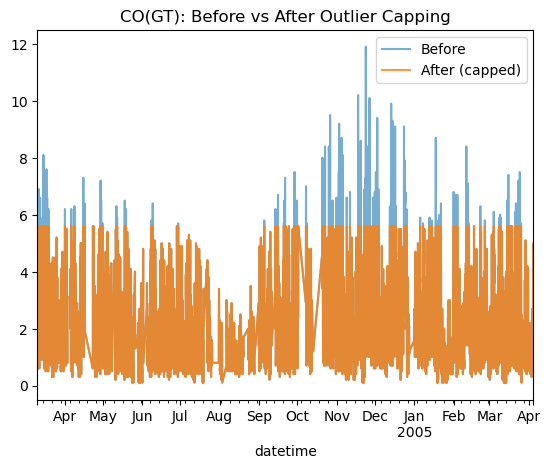

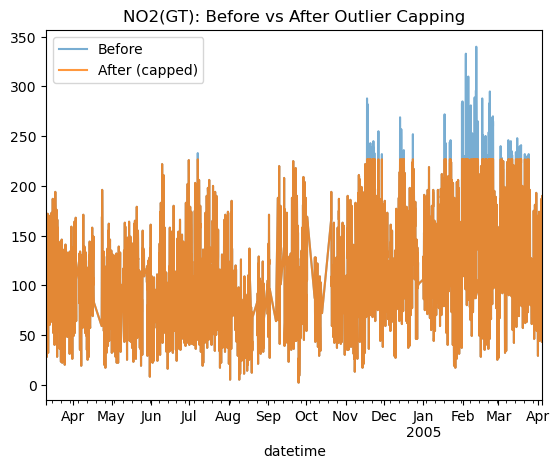

In [12]:
import matplotlib.pyplot as plt

for c in targets:
    plt.figure()
    df_filled[c].plot(alpha=0.6, label="Before")
    df_clean[c].plot(alpha=0.8, label="After (capped)")
    plt.title(f"{c}: Before vs After Outlier Capping")
    plt.legend()
    plt.show()

# Trend Analysis (long-term trends)

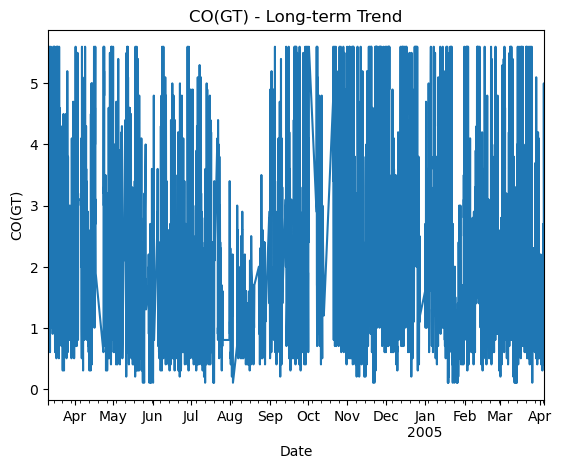

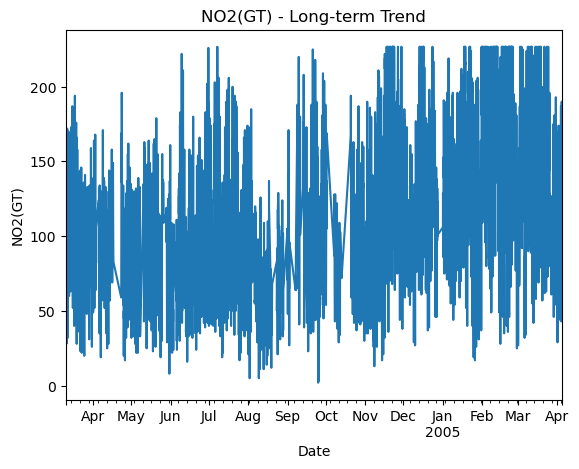

In [13]:
targets = ["CO(GT)", "NO2(GT)"]

for c in targets:
    plt.figure()
    df_clean[c].plot()
    plt.title(f"{c} - Long-term Trend")
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.show()

# Smooth trend line (rolling mean)

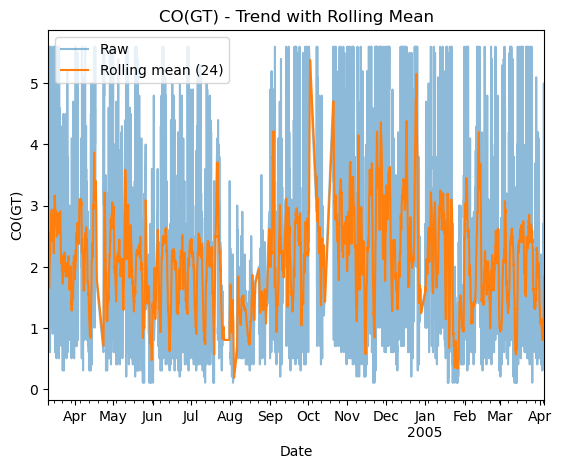

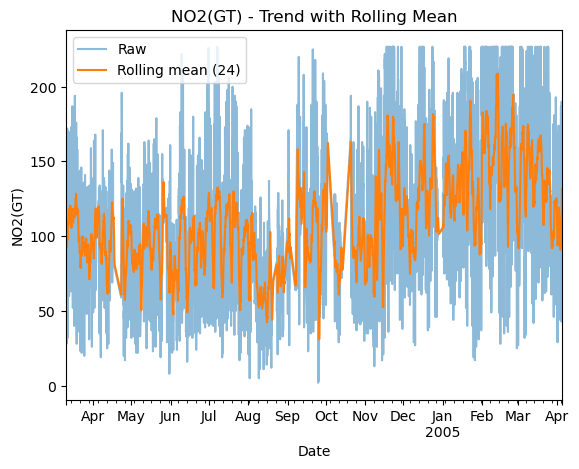

In [14]:
ROLL = 24  

for c in targets:
    plt.figure()
    df_clean[c].plot(alpha=0.5, label="Raw")
    df_clean[c].rolling(ROLL).mean().plot(label=f"Rolling mean ({ROLL})")
    plt.title(f"{c} - Trend with Rolling Mean")
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.legend()
    plt.show()

# Seasonality (daily / weekly patterns)
Average value by hour of day (daily seasonality)

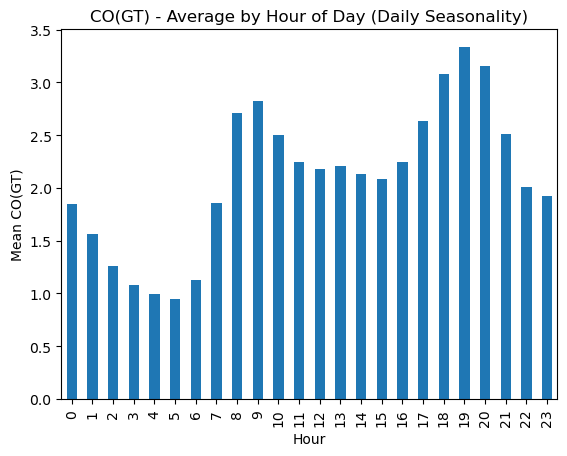

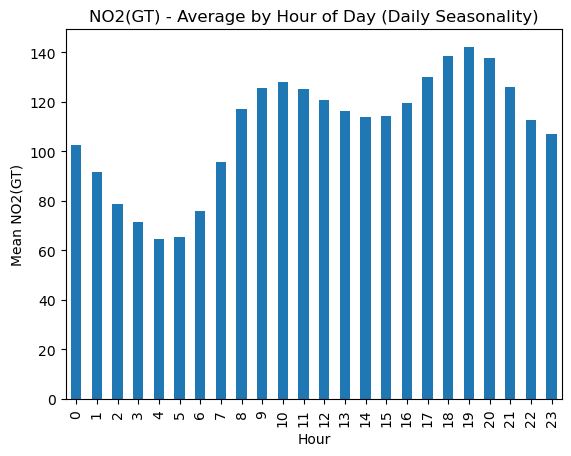

In [16]:
hourly = df_clean.copy()
hourly["hour"] = hourly.index.hour

for c in targets:
    plt.figure()
    hourly.groupby("hour")[c].mean().plot(kind="bar")
    plt.title(f"{c} - Average by Hour of Day (Daily Seasonality)")
    plt.xlabel("Hour")
    plt.ylabel(f"Mean {c}")
    plt.show()

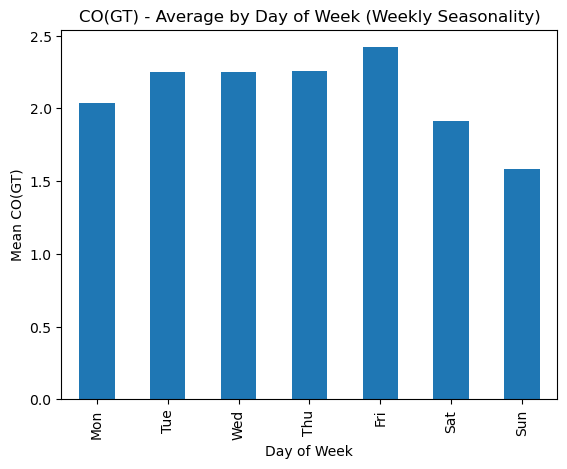

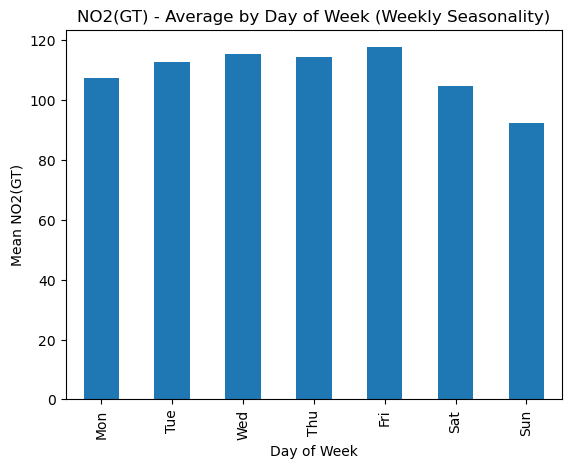

In [54]:
# Average value by day of week (weekly seasonality)
hourly = df_clean.copy()
hourly["dayofweek"] = hourly.index.dayofweek  # 0=Mon ... 6=Sun
dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

for c in ["CO(GT)", "NO2(GT)"]:
    plt.figure()
    (hourly.groupby("dayofweek")[c]
          .mean()
          .rename(index=dict(enumerate(dow_names)))
          .plot(kind="bar"))
    plt.title(f"{c} - Average by Day of Week (Weekly Seasonality)")
    plt.xlabel("Day of Week")
    plt.ylabel(f"Mean {c}")
    plt.show()

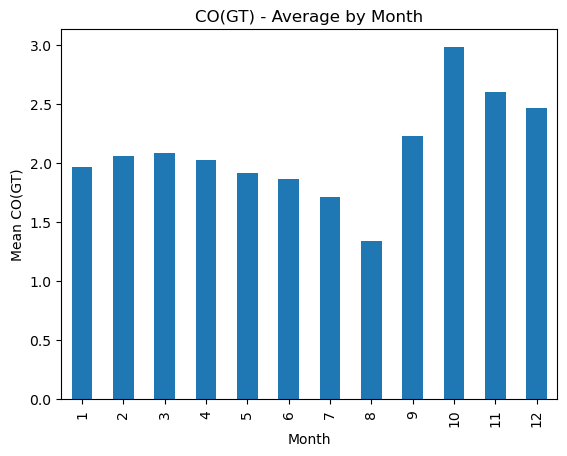

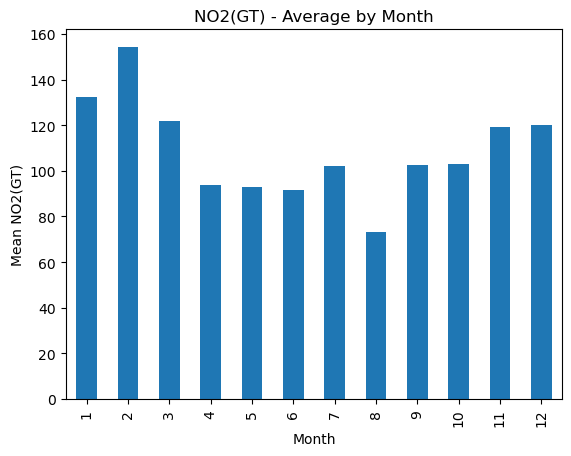

In [19]:
# Monthly seasonality (yearly pattern proxy)

hourly["month"] = hourly.index.month

for c in targets:
    plt.figure()
    hourly.groupby("month")[c].mean().plot(kind="bar")
    plt.title(f"{c} - Average by Month")
    plt.xlabel("Month")
    plt.ylabel(f"Mean {c}")
    plt.show()

# Correlation Analysis (CO/NO2 vs other features)


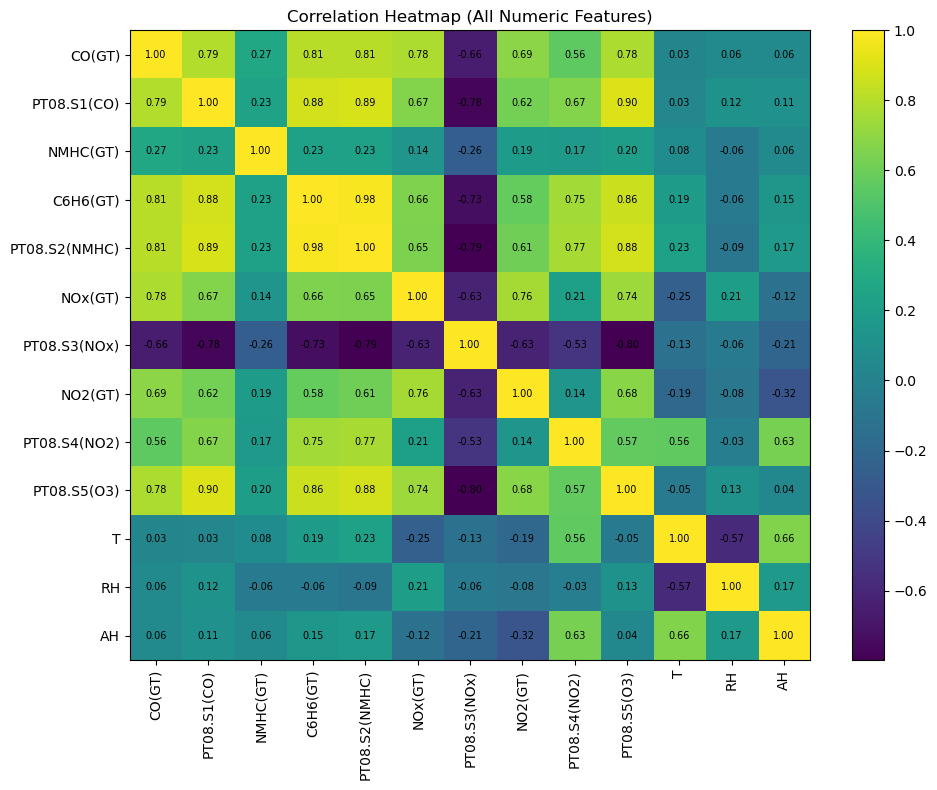

In [59]:
corr = df_clean.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (All Numeric Features)")

# ✅ Add numbers in each cell
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.show()

# Correlation of features with CO and NO2 (ranked list)

In [22]:
for target in ["CO(GT)", "NO2(GT)"]:
    print("\nTop correlations with", target)
    display(
        corr[target].drop(target).sort_values(key=lambda s: s.abs(), ascending=False).head(10)
    )


Top correlations with CO(GT)


PT08.S2(NMHC)    0.809051
C6H6(GT)         0.805169
PT08.S1(CO)      0.793474
PT08.S5(O3)      0.777137
NOx(GT)          0.776438
NO2(GT)          0.687296
PT08.S3(NOx)    -0.660702
PT08.S4(NO2)     0.555643
NMHC(GT)         0.274412
AH               0.062394
Name: CO(GT), dtype: float64


Top correlations with NO2(GT)


NOx(GT)          0.758041
CO(GT)           0.687296
PT08.S5(O3)      0.682054
PT08.S3(NOx)    -0.628838
PT08.S1(CO)      0.622094
PT08.S2(NMHC)    0.608026
C6H6(GT)         0.575173
AH              -0.321211
NMHC(GT)         0.191680
T               -0.189280
Name: NO2(GT), dtype: float64

# Scatter plots with key weather features (T, RH, AH)

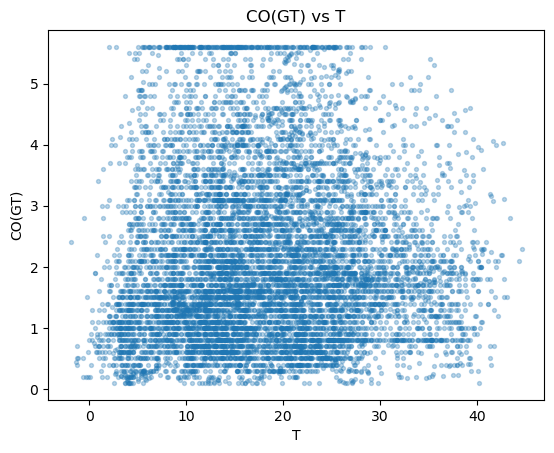

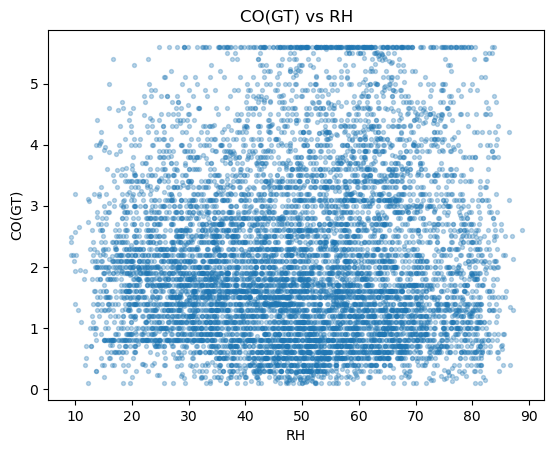

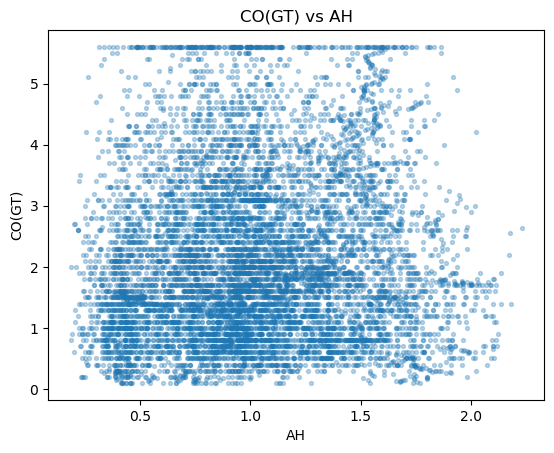

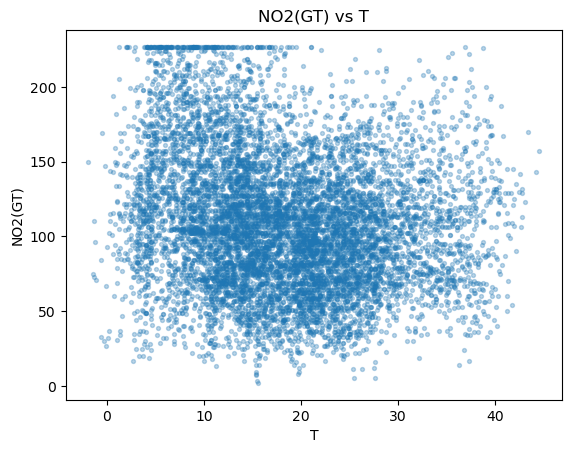

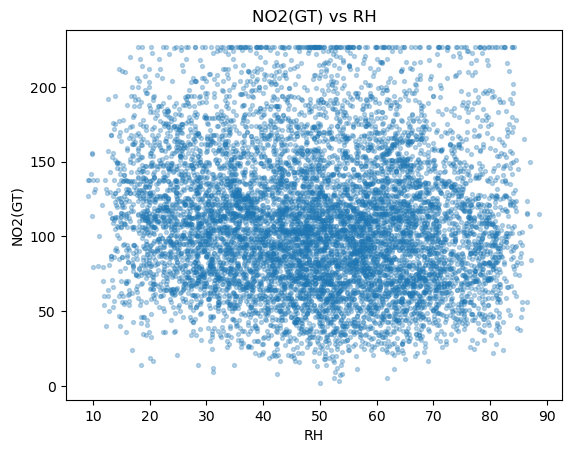

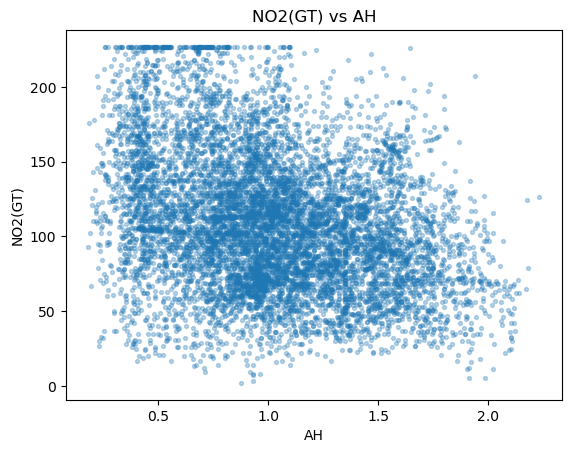

In [23]:
weather = ["T", "RH", "AH"]

for target in targets:
    for w in weather:
        plt.figure()
        plt.scatter(df_clean[w], df_clean[target], s=8, alpha=0.3)
        plt.title(f"{target} vs {w}")
        plt.xlabel(w)
        plt.ylabel(target)
        plt.show()

# Step 3 — Feature Engineering

In [24]:
df_feat = df_clean.copy()

# Time-based features
df_feat["hour"] = df_feat.index.hour
df_feat["day"] = df_feat.index.day
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["month"] = df_feat.index.month

# Environmental predictors (as required)
env_cols = ["T", "RH", "AH"]

# Create lag features for CO and NO2

In [25]:
lag_list = [1, 2, 3, 6, 12, 24, 48, 72]

for lag in lag_list:
    df_feat[f"CO_lag_{lag}"]  = df_feat["CO(GT)"].shift(lag)
    df_feat[f"NO2_lag_{lag}"] = df_feat["NO2(GT)"].shift(lag)

df_feat[[f"CO_lag_{l}" for l in lag_list] + [f"NO2_lag_{l}" for l in lag_list]].head(10)

,CO_lag_1,CO_lag_2,CO_lag_3,CO_lag_6,CO_lag_12,CO_lag_24,CO_lag_48,CO_lag_72,NO2_lag_1,NO2_lag_2,NO2_lag_3,NO2_lag_6,NO2_lag_12,NO2_lag_24,NO2_lag_48,NO2_lag_72
datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 19:00:00,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 20:00:00,2.0,2.6,NaN,NaN,NaN,NaN,NaN,NaN,92.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 21:00:00,2.2,2.0,2.6,NaN,NaN,NaN,NaN,NaN,114.0,92.0,113.0,NaN,NaN,NaN,NaN,NaN
2004-03-10 22:00:00,2.2,2.2,2.0,NaN,NaN,NaN,NaN,NaN,122.0,114.0,92.0,NaN,NaN,NaN,NaN,NaN
2004-03-10 23:00:00,1.6,2.2,2.2,NaN,NaN,NaN,NaN,NaN,116.0,122.0,114.0,NaN,NaN,NaN,NaN,NaN
2004-03-11 00:00:00,1.2,1.6,2.2,2.6,NaN,NaN,NaN,NaN,96.0,116.0,122.0,113.0,NaN,NaN,NaN,NaN
2004-03-11 01:00:00,1.2,1.2,1.6,2.0,NaN,NaN,NaN,NaN,77.0,96.0,116.0,92.0,NaN,NaN,NaN,NaN
2004-03-11 02:00:00,1.0,1.2,1.2,2.2,NaN,NaN,NaN,NaN,76.0,77.0,96.0,114.0,NaN,NaN,NaN,NaN


# Rolling features

In [27]:
windows = [3, 6, 24]  # hours

for w in windows:
    df_feat[f"CO_rollmean_{w}"] = df_feat["CO(GT)"].shift(1).rolling(w).mean()
    df_feat[f"NO2_rollmean_{w}"] = df_feat["NO2(GT)"].shift(1).rolling(w).mean()

# Drop rows made NaN by lagging 

In [28]:
before = len(df_feat)
df_feat = df_feat.dropna()
after = len(df_feat)

print("Rows before:", before, "| after dropping lag-NaNs:", after)
df_feat.head()

Rows before: 9357 | after dropping lag-NaNs: 9285


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,CO_lag_48,NO2_lag_48,CO_lag_72,NO2_lag_72,CO_rollmean_3,NO2_rollmean_3,CO_rollmean_6,NO2_rollmean_6,CO_rollmean_24,NO2_rollmean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-13 18:00:00,3.2,1473.0,191.0,15.5,1163.0,227.0,831.0,148.0,1779.0,1395.0,...,4.8,151.0,2.6,113.0,2.266667,121.666667,2.533333,125.333333,2.847917,116.520833
2004-03-13 19:00:00,4.2,1609.0,258.0,19.6,1286.0,277.0,758.0,165.0,1922.0,1612.0,...,5.6,172.0,2.0,92.0,2.666667,132.333333,2.466667,123.166667,2.818750,116.479167
2004-03-13 20:00:00,4.2,1611.0,284.0,19.2,1274.0,279.0,754.0,161.0,1915.0,1697.0,...,5.6,165.0,2.2,114.0,3.233333,146.000000,2.700000,130.000000,2.839583,117.312500
2004-03-13 21:00:00,4.2,1621.0,269.0,18.3,1247.0,283.0,762.0,159.0,1860.0,1886.0,...,3.9,136.0,2.2,122.0,3.866667,158.000000,3.066667,139.833333,2.781250,116.937500
2004-03-13 22:00:00,3.1,1444.0,180.0,13.1,1089.0,214.0,844.0,143.0,1748.0,1624.0,...,1.5,85.0,1.6,116.0,4.200000,161.666667,3.433333,147.000000,2.772917,117.354167


# Step 4 — Time-Series Forecasting

Train/Validation/Test split (time-based)

In [29]:
TARGETS = ["CO(GT)", "NO2(GT)"]

def split_time_df(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    train = df.iloc[:train_end]
    val   = df.iloc[train_end:val_end]
    test  = df.iloc[val_end:]
    return train, val, test

train_df, val_df, test_df = split_time_df(df_feat)

print(train_df.index.min(), "→", train_df.index.max())
print(val_df.index.min(),   "→", val_df.index.max())
print(test_df.index.min(),  "→", test_df.index.max())

2004-03-13 18:00:00 → 2004-12-09 12:00:00
2004-12-09 13:00:00 → 2005-02-05 13:00:00
2005-02-05 14:00:00 → 2005-04-04 14:00:00


In [30]:
def MAE(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Statistical Model — SARIMA (univariate)

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima_forecast(y_train, y_test, order=(1,1,1), seasonal_order=(1,0,1,24)):
    model = SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    pred = res.forecast(steps=len(y_test))
    pred.index = y_test.index
    return pred, res

# SARIMA for CO and NO2:

In [56]:
sarima_results = {}

for target in TARGETS:
    y_train = train_df[target]
    y_test  = test_df[target]

    pred, res = fit_sarima_forecast(
        y_train, y_test,
        order=(1,1,1),
        seasonal_order=(1,0,1,24)
    )

    sarima_results[target] = pred
    print(target, "SARIMA MAE:", MAE(y_test, pred), "RMSE:", RMSE(y_test, pred))

CO(GT) SARIMA MAE: 3.470021945746497 RMSE: 3.8681364396466797
NO2(GT) SARIMA MAE: 115.65611431452481 RMSE: 123.88298994517135


# Machine Learning — Regression on lag + external predictors

We’ll use a strong, simple baseline: RandomForestRegressor (works well without heavy tuning).
Also: we must scale only for linear models; tree models don’t need scaling

In [34]:
# Prepare X/y
from sklearn.ensemble import RandomForestRegressor

# Define feature columns: everything except targets
feature_cols = [c for c in df_feat.columns if c not in TARGETS]

X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]
X_test  = test_df[feature_cols]

In [35]:
# Train RF models for CO and NO2
ml_results = {}

for target in TARGETS:
    y_train = train_df[target]
    y_test  = test_df[target]

    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred = pd.Series(rf.predict(X_test), index=y_test.index)

    ml_results[target] = pred
    print(target, "RF MAE:", MAE(y_test, pred), "RMSE:", RMSE(y_test, pred))

CO(GT) RF MAE: 0.2904050893675042 RMSE: 0.4097088930152157
NO2(GT) RF MAE: 14.583371310190692 RMSE: 19.354897530449417


# Train RF models for CO and NO2

In [36]:
ml_results = {}

for target in TARGETS:
    y_train = train_df[target]
    y_test  = test_df[target]

    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred = pd.Series(rf.predict(X_test), index=y_test.index)

    ml_results[target] = pred
    print(target, "RF MAE:", MAE(y_test, pred), "RMSE:", RMSE(y_test, pred))

CO(GT) RF MAE: 0.2904050893675042 RMSE: 0.4097088930152157
NO2(GT) RF MAE: 14.583371310190689 RMSE: 19.354897530449417


# Deep Learning — LSTM (sequence forecasting)

# Sequences of length SEQ_LEN using the same features.
Important: scale features using train only to avoid leakage.


In [37]:
# Build sequences + scale

from sklearn.preprocessing import StandardScaler

SEQ_LEN = 24  # use past 24 hours to predict next hour

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

def make_sequences(X_scaled, y_series, seq_len):
    Xs, ys = [], []
    X_scaled = np.asarray(X_scaled)
    y = y_series.values
    for i in range(seq_len, len(y)):
        Xs.append(X_scaled[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys), y_series.index[seq_len:]

# CO sequences
Xtr_co, ytr_co, idx_tr_co = make_sequences(X_train_scaled, train_df["CO(GT)"], SEQ_LEN)
Xte_co, yte_co, idx_te_co = make_sequences(X_test_scaled,  test_df["CO(GT)"],  SEQ_LEN)

# NO2 sequences
Xtr_no2, ytr_no2, idx_tr_no2 = make_sequences(X_train_scaled, train_df["NO2(GT)"], SEQ_LEN)
Xte_no2, yte_no2, idx_te_no2 = make_sequences(X_test_scaled,  test_df["NO2(GT)"],  SEQ_LEN)

Xtr_co.shape, Xte_co.shape

((6475, 24, 37), (1369, 24, 37))

# LSTM model (Keras)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lstm(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

In [39]:
# Train + predict:

dl_results = {}

# CO
model_co = build_lstm(Xtr_co.shape[1:])
model_co.fit(Xtr_co, ytr_co, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
pred_co = model_co.predict(Xte_co).ravel()
dl_results["CO(GT)"] = pd.Series(pred_co, index=idx_te_co)

print("CO LSTM MAE:", MAE(yte_co, pred_co), "RMSE:", RMSE(yte_co, pred_co))

# NO2
model_no2 = build_lstm(Xtr_no2.shape[1:])
model_no2.fit(Xtr_no2, ytr_no2, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
pred_no2 = model_no2.predict(Xte_no2).ravel()
dl_results["NO2(GT)"] = pd.Series(pred_no2, index=idx_te_no2)

print("NO2 LSTM MAE:", MAE(yte_no2, pred_no2), "RMSE:", RMSE(yte_no2, pred_no2))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.1845 - val_loss: 0.7810
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4035 - val_loss: 0.6701
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3163 - val_loss: 0.6503
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2690 - val_loss: 0.6725
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2430 - val_loss: 0.6290
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2249 - val_loss: 0.6524
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2134 - val_loss: 0.6520
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2098 - val_loss: 0.7087
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1904 - val_loss: 0.6942
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1816 - val_loss: 0.6738
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
CO LSTM MAE: 0.5234167370115257 RMSE: 0.6938981172658177
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 777

In [41]:
# Compare models (evaluation table)

results_rows = []

for target in TARGETS:
    y_true = test_df[target]

    # SARIMA
    pred_s = sarima_results[target]
    results_rows.append([target, "SARIMA", MAE(y_true, pred_s), RMSE(y_true, pred_s)])

    # ML
    pred_m = ml_results[target]
    results_rows.append([target, "RandomForest", MAE(y_true, pred_m), RMSE(y_true, pred_m)])

    # DL: align because LSTM loses first SEQ_LEN points
    pred_d = dl_results[target]
    y_true_d = y_true.loc[pred_d.index]
    results_rows.append([target, "LSTM", MAE(y_true_d, pred_d), RMSE(y_true_d, pred_d)])

results_table = pd.DataFrame(results_rows, columns=["Target", "Model", "MAE", "RMSE"])
results_table

,Target,Model,MAE,RMSE
0,CO(GT),SARIMA,3.470022,3.868136
1,CO(GT),RandomForest,0.290405,0.409709
2,CO(GT),LSTM,0.523417,0.693898
3,NO2(GT),SARIMA,115.656114,123.882990
4,NO2(GT),RandomForest,14.583371,19.354898
5,NO2(GT),LSTM,26.267192,35.745614


# Forecast visualization (historical + predictions)

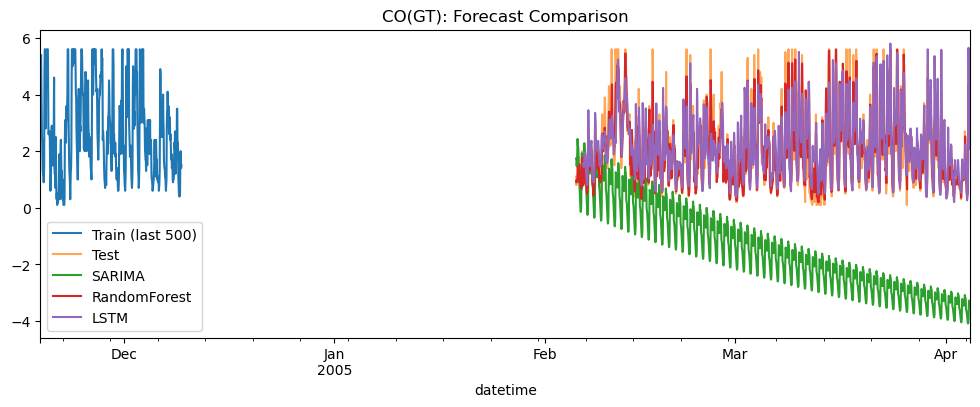

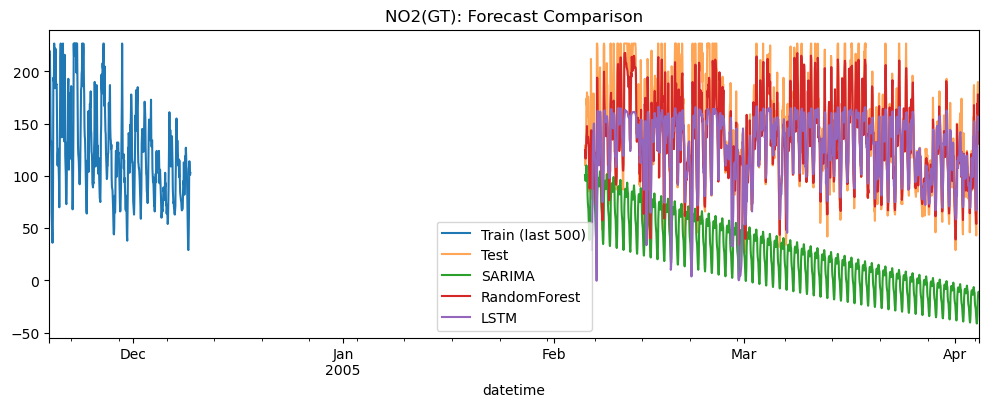

In [42]:
def plot_forecasts(target):
    plt.figure(figsize=(12,4))
    # show last part of train + full test
    train_df[target].iloc[-500:].plot(label="Train (last 500)")
    test_df[target].plot(label="Test", alpha=0.7)

    sarima_results[target].plot(label="SARIMA")
    ml_results[target].plot(label="RandomForest")

    # LSTM might start later
    dl_results[target].plot(label="LSTM")

    plt.title(f"{target}: Forecast Comparison")
    plt.legend()
    plt.show()

plot_forecasts("CO(GT)")
plot_forecasts("NO2(GT)")

# Step 5 — Model Evaluation (MAE, RMSE, MAPE + Actual vs Predicted plots)

Metrics functions (including safe MAPE)

MAPE breaks when actual values are 0. Your CO/NO2 can get close to 0, so we use a safe version.

In [43]:
def MAE(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def MAPE(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)  # avoid division by 0
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# Build evaluation table for CO and NO2
This assumes:

test_df[target]

predictions stored like:

sarima_results[target]

ml_results[target]

dl_results[target] 

In [44]:
rows = []
TARGETS = ["CO(GT)", "NO2(GT)"]

for target in TARGETS:
    y_true = test_df[target]

    # SARIMA
    pred = sarima_results[target].reindex(y_true.index)
    rows.append([target, "SARIMA", MAE(y_true, pred), RMSE(y_true, pred), MAPE(y_true, pred)])

    # ML
    pred = ml_results[target].reindex(y_true.index)
    rows.append([target, "Regression/ML", MAE(y_true, pred), RMSE(y_true, pred), MAPE(y_true, pred)])

    # DL (align because it loses first SEQ_LEN points)
    pred = dl_results[target]
    y_true_aligned = y_true.loc[pred.index]
    rows.append([target, "LSTM", MAE(y_true_aligned, pred), RMSE(y_true_aligned, pred), MAPE(y_true_aligned, pred)])

eval_table = pd.DataFrame(rows, columns=["Target", "Model", "MAE", "RMSE", "MAPE(%)"])
eval_table

,Target,Model,MAE,RMSE,MAPE(%)
0,CO(GT),SARIMA,3.470022,3.868136,268.559367
1,CO(GT),Regression/ML,0.290405,0.409709,21.845639
2,CO(GT),LSTM,0.523417,0.693898,48.415169
3,NO2(GT),SARIMA,115.656114,123.882990,84.665060
4,NO2(GT),Regression/ML,14.583371,19.354898,10.714922
5,NO2(GT),LSTM,26.267192,35.745614,19.923326


In [60]:
eval_table_rounded = eval_table.copy()
eval_table_rounded[["MAE","RMSE","MAPE(%)"]] = eval_table_rounded[["MAE","RMSE","MAPE(%)"]].round(3)
eval_table_rounded

,Target,Model,MAE,RMSE,MAPE(%)
0,CO(GT),SARIMA,3.470,3.868,268.559
1,CO(GT),Regression/ML,0.290,0.410,21.846
2,CO(GT),LSTM,0.523,0.694,48.415
3,NO2(GT),SARIMA,115.656,123.883,84.665
4,NO2(GT),Regression/ML,14.583,19.355,10.715
5,NO2(GT),LSTM,26.267,35.746,19.923


# Model Evaluation Summary

The forecasting models were evaluated using MAE, RMSE, and MAPE on the held-out test set for both CO(GT) and NO₂(GT). For CO(GT), the Regression/ML model achieved the best performance (MAE ≈ 0.29, RMSE ≈ 0.41), outperforming the LSTM and SARIMA models. For NO₂(GT), the Regression/ML model also performed best (MAE ≈ 14.58, RMSE ≈ 19.35), while the LSTM achieved moderate accuracy and SARIMA performed poorly.
Note: MAPE can become extremely large when true values are close to zero (small denominator), which explains the unusually high MAPE for CO(GT) under SARIMA; MAE and RMSE are therefore more reliable for comparison in this case. Overall, the Regression/ML approach provided the most accurate and stable forecasts across both pollutants.

#Note on MAPE: MAPE can become extremely large when true pollutant values are close to zero (small denominator), which makes it less stable for CO(GT) in this dataset. Therefore, MAE and RMSE are more reliable for model comparison here.

# Actual vs Predicted plots 

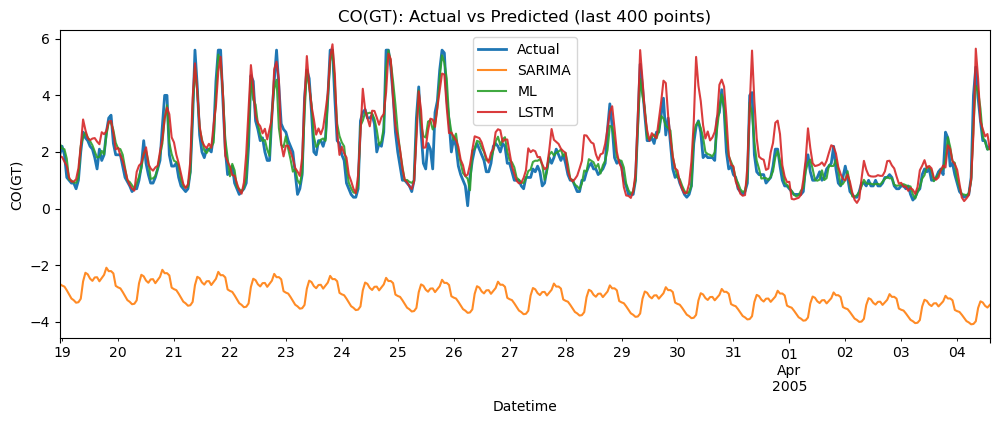

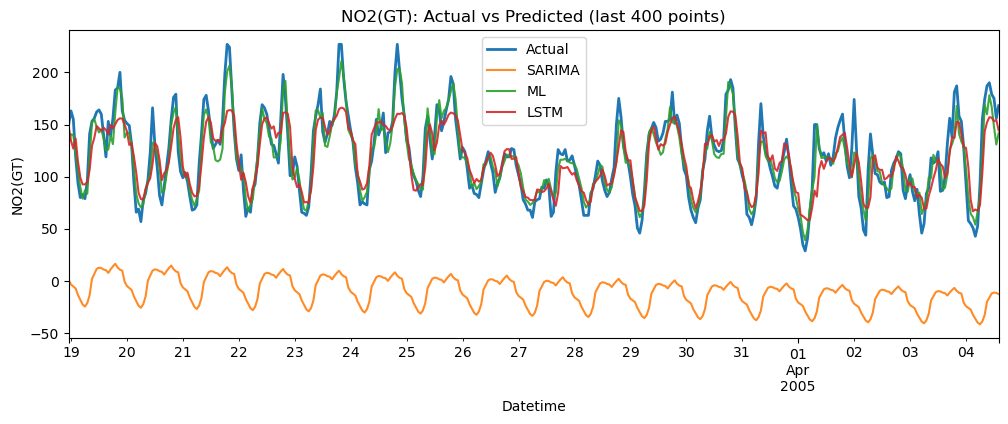

In [45]:
def plot_actual_vs_pred(target, y_true, pred_dict, zoom=400):
    plt.figure(figsize=(12,4))
    y_true.iloc[-zoom:].plot(label="Actual", linewidth=2)

    for name, pred in pred_dict.items():
        # align with y_true index
        pred_aligned = pred.reindex(y_true.index)
        pred_aligned.iloc[-zoom:].plot(label=name, alpha=0.9)

    plt.title(f"{target}: Actual vs Predicted (last {zoom} points)")
    plt.xlabel("Datetime")
    plt.ylabel(target)
    plt.legend()
    plt.show()

for target in TARGETS:
    y_true = test_df[target]
    preds = {
        "SARIMA": sarima_results[target],
        "ML": ml_results[target],
        "LSTM": dl_results[target],
    }
    plot_actual_vs_pred(target, y_true, preds, zoom=400)

# Step 6 — Visualization and Insights (future forecast + peaks + recommendations)
There are two parts:

Future forecasts (e.g., next 24 or 48 hours)

Identify peak times and “periods of concern”

# Future forecasting (next 48 hours) using SARIMA (easy + standard)

SARIMA can forecast future steps directly.

In [47]:
FORECAST_H = 48  # next 48 hours (change if your instructor wants 24 or 7 days)

future_forecasts = {}

for target in TARGETS:
    y_full = df_feat[target]  # or df_clean[target] if you used univariate only

    # Fit SARIMA on full history (best for future forecast plot)
    model = SARIMAX(
        y_full,
        order=(1,1,1),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    future = res.forecast(steps=FORECAST_H)

    # build future datetime index
    last_time = y_full.index[-1]
    future.index = pd.date_range(start=last_time + pd.Timedelta(hours=1),
                                 periods=FORECAST_H, freq="h")

    future_forecasts[target] = future
    print(target, "future forecast from", future.index.min(), "to", future.index.max())

CO(GT) future forecast from 2005-04-04 15:00:00 to 2005-04-06 14:00:00
NO2(GT) future forecast from 2005-04-04 15:00:00 to 2005-04-06 14:00:00


# Plot history + future forecast (required visualization)


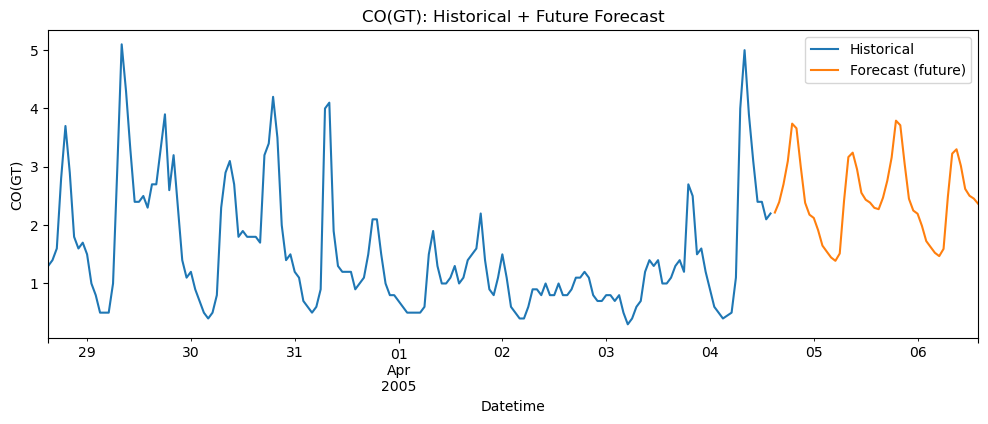

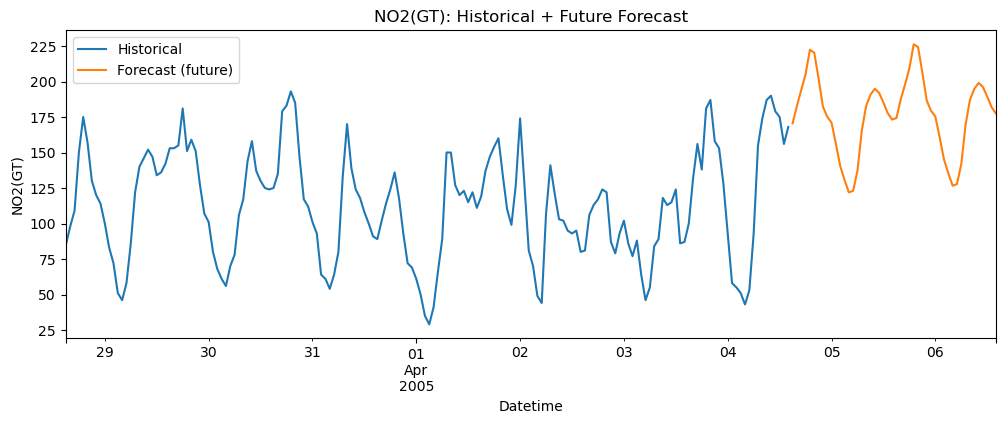

In [49]:
HIST_WINDOW = 7 * 24  # show last 7 days of history

for target in TARGETS:
    plt.figure(figsize=(12,4))
    df_feat[target].iloc[-HIST_WINDOW:].plot(label="Historical")
    future_forecasts[target].plot(label="Forecast (future)")
    plt.title(f"{target}: Historical + Future Forecast")
    plt.xlabel("Datetime")
    plt.ylabel(target)
    plt.legend()
    plt.show()

# Highlight peak times + periods of concern (simple & clear)

In [50]:
insights = {}

for target in TARGETS:
    series = df_clean[target]
    thresh = series.quantile(0.90)  # top 10%
    high_times = series[series >= thresh]

    # peak hour-of-day
    peak_hour = high_times.groupby(high_times.index.hour).mean().idxmax()

    # peak day-of-week
    peak_dow = high_times.groupby(high_times.index.dayofweek).mean().idxmax()

    insights[target] = {
        "threshold_90pct": float(thresh),
        "peak_hour": int(peak_hour),
        "peak_dayofweek": int(peak_dow),
        "high_count": int(len(high_times))
    }

insights

{'CO(GT)': {'threshold_90pct': 4.1,
  'peak_hour': 17,
  'peak_dayofweek': 4,
  'high_count': 957},
 'NO2(GT)': {'threshold_90pct': 172.0,
  'peak_hour': 9,
  'peak_dayofweek': 3,
  'high_count': 942}}

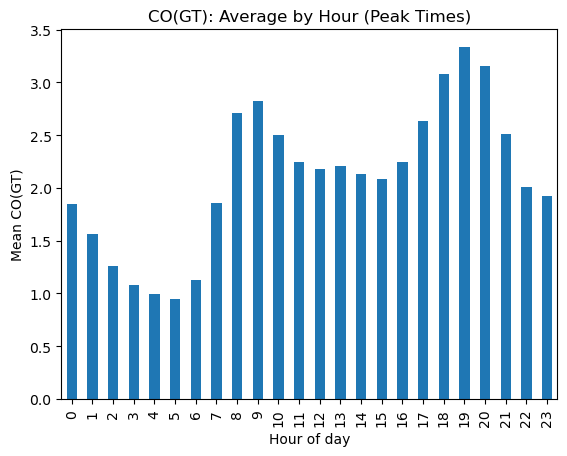

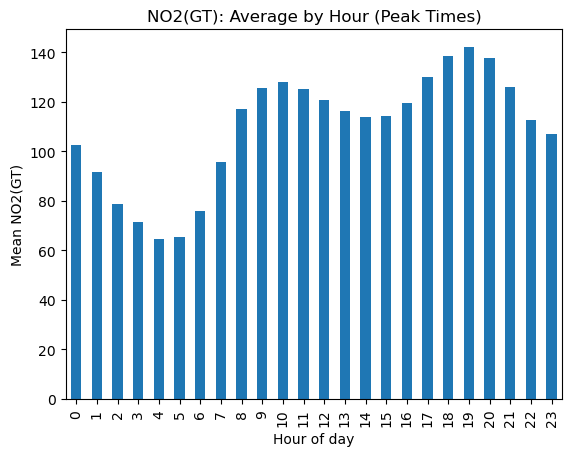

In [52]:
# Bar plot of average by hour to highlight peak times)

tmp = df_clean.copy()
tmp["hour"] = tmp.index.hour

for target in TARGETS:
    plt.figure()
    tmp.groupby("hour")[target].mean().plot(kind="bar")
    plt.title(f"{target}: Average by Hour (Peak Times)")
    plt.xlabel("Hour of day")
    plt.ylabel(f"Mean {target}")
    plt.show()

# Forecast next 48 hours (hourly) + plot

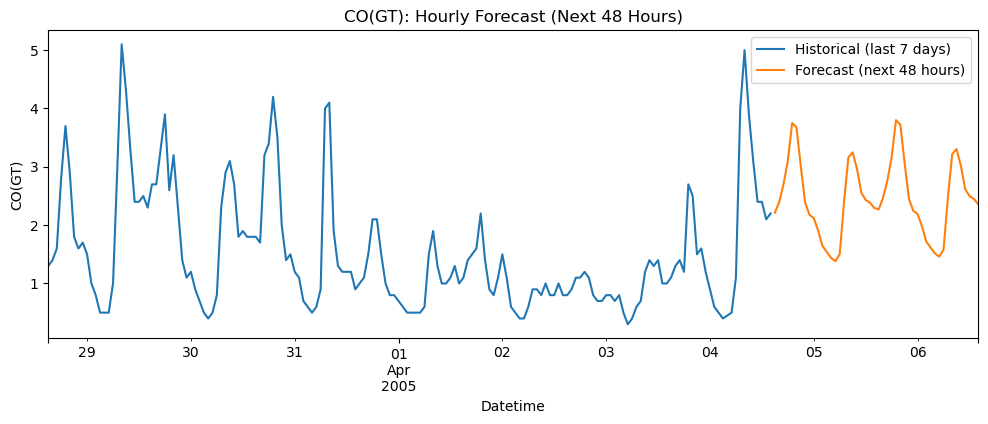

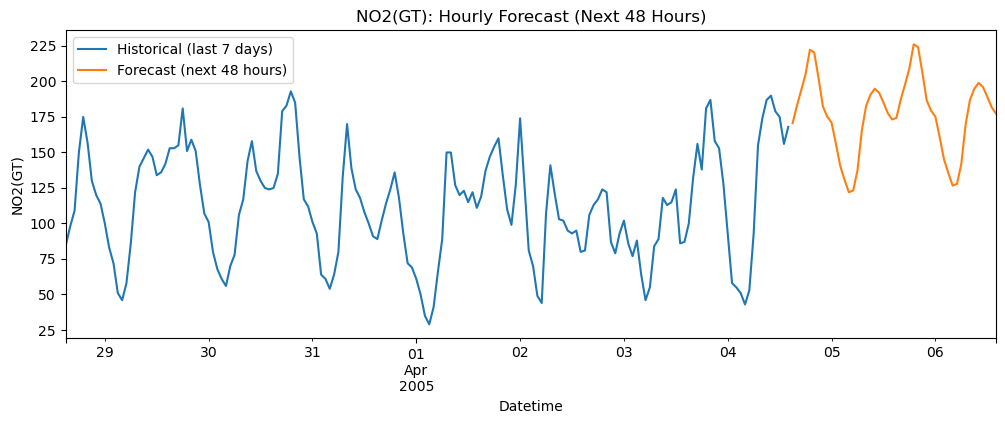

In [57]:
FORECAST_H = 48  # next 48 hours

future_forecasts = {}

for target in ["CO(GT)", "NO2(GT)"]:
    y_full = df_clean[target]  # univariate for SARIMA

    model = SARIMAX(
        y_full,
        order=(1,1,1),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    future = res.forecast(steps=FORECAST_H)
    future.index = pd.date_range(
        start=y_full.index[-1] + pd.Timedelta(hours=1),
        periods=FORECAST_H,
        freq="h"
    )
    future_forecasts[target] = future

    # Plot last 7 days + future
    plt.figure(figsize=(12,4))
    y_full.iloc[-7*24:].plot(label="Historical (last 7 days)")
    future.plot(label="Forecast (next 48 hours)")
    plt.title(f"{target}: Hourly Forecast (Next 48 Hours)")
    plt.xlabel("Datetime")
    plt.ylabel(target)
    plt.legend()
    plt.show()

# Highlight “periods of concern” from the forecast

In [58]:
for target in ["CO(GT)", "NO2(GT)"]:
    hist_thresh = df_clean[target].quantile(0.90)
    future = future_forecasts[target]
    high_future = future[future >= hist_thresh]

    print(f"\n{target}")
    print(f"Historical 90th percentile threshold: {hist_thresh:.3f}")
    print(f"High-risk forecast hours (count): {len(high_future)}")

    if len(high_future) > 0:
        print("First 10 high-risk hours:")
        display(high_future.head(10))


CO(GT)
Historical 90th percentile threshold: 4.100
High-risk forecast hours (count): 0

NO2(GT)
Historical 90th percentile threshold: 172.000
High-risk forecast hours (count): 32
First 10 high-risk hours:


2005-04-04 16:00:00    182.843147
2005-04-04 17:00:00    194.031164
2005-04-04 18:00:00    205.159077
2005-04-04 19:00:00    222.346135
2005-04-04 20:00:00    220.335323
2005-04-04 21:00:00    202.281090
2005-04-04 22:00:00    182.459703
2005-04-04 23:00:00    175.243562
2005-04-05 08:00:00    182.831169
2005-04-05 09:00:00    190.684549
Name: predicted_mean, dtype: float64

# “Actionable Recommendations”
Focus mitigation on NO₂ over the next 48 hours: The forecast shows NO₂ exceeds the historical 90th percentile threshold (172) for 32 hours, indicating a sustained high-risk period. Prioritize NO₂ reduction strategies during this window.

Time-targeted traffic measures: The first high-risk NO₂ hours begin around 16:00–23:00 on 2005-04-04 and continue into the next day (including morning hours). During these periods, reduce congestion and emissions by optimizing signal timing, restricting heavy-duty vehicles where feasible, and discouraging idling near dense areas.

Public health advisory during high-risk hours: Recommend sensitive groups (asthma patients, elderly, children) limit outdoor activity during predicted high-risk NO₂ hours; suggest indoor ventilation/filtration strategies if available.

Operational adjustments for local emission sources: If industrial or generator loads are relevant, shift non-essential high-emission activities away from the predicted high-risk NO₂ hours.

CO outlook: CO remains below the “high-risk” threshold (90th percentile ≈ 4.1) in the next 48 hours, so no immediate high-risk CO event is indicated; continue routine monitoring since short spikes can still occur.

Ongoing improvement: Re-train models periodically and monitor MAE/RMSE to ensure accuracy remains stable as new data arrives.